# behley2019iccv

> Module to handle loading, preprocessing and postprocessing of the data from [SemanticKITTI: A Dataset for Semantic Scene Understanding of LiDAR Sequences](https://arxiv.org/pdf/1904.01416).

In [ ]:
#| default_exp behley2019iccv

In [ ]:
#| export
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import yaml
from pathlib import Path
import numpy as np
from torchvision.transforms import v2

## [semantic-kitti-api](https://github.com/PRBonn/semantic-kitti-api)

This is an adaptation of the code from the semantic-kitti-api as a pytorch [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

Summarizing quotes from the paper:

### 1. Introduction
> - "we annotated all 22 sequences of the odometry benchmark of the [KITTI Vision Benchmark](https://www.cvlibs.net/publications/Geiger2012CVPR.pdf) consisting of over 43 000 scans"
### 3. The SemanticKITTI Dataset
> - "showing inner city traffic, residential areas, but also highway scenes and countryside roads around Karlsruhe, Germany"
> - "splitting sequences **00 to 10 as training set**, and **11 to 21 as test set**. For consistency [...], we adopt the same division for our training and test set [as the [KITTI Vision Benchmark](https://www.cvlibs.net/publications/Geiger2012CVPR.pdf)]"
> - "we provide **23201** full 3D scans for training and **20351** for testing"
> - "we **do not** distinguish between persons riding a vehicle and the vehicle, but label the vehicle and the person as either bicyclist or motorcyclist"
> - "we have **28 classes**, where **6 classes** are assigned the attribute **moving or non-moving**, and **one outlier class** is included for erroneous laser measurements caused by reflections or other effects"
#### 3.1 Labeling process
> - "we first register and loop close the sequences using an off-the-shelf laser-based SLAM system"
> - "For three sequences, we had to **manually** add loop closure constraints to get correctly loop closed trajectories"
> - "We subdivide the sequence of point clouds into tiles of **100 m by 100 m** [...] This enables us to label all scans consistently even when we encounter temporally distant loop closures"
> - "An annotator needs on average **4.5 hours per tile**, when labeling **residential areas** [...], and needs on average **1.5 hours** for labeling a **highway** tile."
> - "the whole dataset comprises **518 tiles**"
### 4. Evaluation of Semantic Segmentation
#### 4.1 Single Scan Experiments
> - "we use **25** instead of 28 classes, **ignoring** *outlier*, *other-structure*, and *other-object* during training and inference"
> - "we **cannot** expect to distinguish *moving* from *non-moving* objects with a **single scan** [...] We therefore combine the moving classes with the corresponding non-moving class resulting in a total number of **19 classes** for training and evaluation"
> - "In the case of a rotating LiDAR, all points of a single turn can be projected to an image by using a **spherical projection**"
> - "classes with **few examples**, like *motorcyclists* and *trucks*, seem to be more difficult"
> - "classes with only a small number of points in a single point cloud, like *bicycles* and *poles*, are **hard classes**"

In [ ]:
#| exports
class SemanticKITTIDataset(Dataset):
    "Load the SemanticKITTI data in a pytorch Dataset object."
    def __init__(self, data_path, split='train', transform=None, remapping_rules=None):
        data_path = Path(data_path)
        yaml_path = data_path/'semantic-kitti.yaml'
        self.velodyne_path = data_path/'data_odometry_velodyne/dataset/sequences'
        self.labels_path = data_path/'data_odometry_labels/dataset/sequences'

        with open(yaml_path, 'r') as file:
            metadata = yaml.safe_load(file)
        
        if split != 'none':
            sequences = metadata['split'][split]
            velodyne_fns = []
            for seq in sequences:
                velodyne_fns += list(self.velodyne_path.rglob(f'*{seq:02}/velodyne/*.bin'))
            
            self.frame_ids = [fn.stem for fn in velodyne_fns]
            self.frame_sequences = [fn.parts[-3] for fn in velodyne_fns]
        self.split = split
        
        self.labels_dict = metadata['labels']
        
        self.content = metadata['content']
        max_key = sorted(self.content.keys())[-1]
        self.content_np = np.zeros((max_key+1,), dtype=np.float32)
        for k, v in self.content.items():
            self.content_np[k] = v
        
        self.learning_map = metadata['learning_map']
        self.learning_map_np = np.zeros((max_key+1,), dtype=np.uint32)
        for k, v in self.learning_map.items():
            self.learning_map_np[k] = v
        
        self.learning_map_inv = metadata['learning_map_inv']
        self.learning_map_inv_np = np.zeros((len(self.learning_map_inv),), dtype=np.uint32)
        content_sum_np = np.zeros_like(self.learning_map_inv_np, dtype=np.float32)
        for k, v in self.learning_map_inv.items():
            self.learning_map_inv_np[k] = v
            content_sum_np[k] = self.content_np[self.learning_map_np == k].sum()
        self.content_weights = 1./content_sum_np
        
        self.color_map_bgr = metadata['color_map']
        self.color_map_rgb_np = np.zeros((max_key+1, 3), dtype=np.float32)
        for k, v in self.color_map_bgr.items():
            self.color_map_rgb_np[k] = np.array(v[::-1], np.float32)
        
        self.transform = transform
        self.is_test = (split == 'test')

        if remapping_rules is not None:
            self.learning_remap(remapping_rules)
    
    def learning_remap(self, remapping_rules):
        new_map_np = np.zeros_like(self.learning_map_np, dtype=np.uint32)
        max_key = sorted(remapping_rules.values())[-1]
        new_map_inv_np = np.zeros((max_key+1,), dtype=np.uint32)
        for k, v in remapping_rules.items():
            new_map_np[self.learning_map_np == k] = v
            if new_map_inv_np[v] == 0:
                new_map_inv_np[v] = self.learning_map_inv_np[k]
        
        new_content_sum_np = np.zeros_like(new_map_inv_np, dtype=np.float32)
        for k in range(len(new_map_inv_np)):
            new_content_sum_np[k] = self.content_np[new_map_np == k].sum()
        
        self.learning_map_np = new_map_np
        self.learning_map_inv_np = new_map_inv_np
        self.content_weights = 1./new_content_sum_np
    
    def set_transform(self, transform):
        self.transform = transform
    
    def __len__(self):
        return len(self.frame_ids)

    def __getitem__(self, idx):
        assert self.split != 'none'
        
        frame_id = self.frame_ids[idx]
        frame_sequence = self.frame_sequences[idx]
        
        frame_path = self.velodyne_path/frame_sequence/'velodyne'/(frame_id + '.bin')
        with open(frame_path, 'rb') as f:
            frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
        
        label = None
        mask = None
        if not self.is_test:
            label_path = self.labels_path/frame_sequence/'labels'/(frame_id + '.label')
            with open(label_path, 'rb') as f:
                label = np.fromfile(f, dtype=np.uint32)
                label = label & 0xFFFF
            label = self.learning_map_np[label]
            mask = label != 0   # see the field *learning_ignore* in the yaml file
        
        item = {
            'frame': frame,
            'label': label,
            'mask': mask
        }
        if self.transform:
            item = self.transform(item)
        
        return item

To use the `SemanticKITTIDataset` class, start by downloading the required files from the provided links on their [official website](http://semantic-kitti.org/dataset.html#download). Then, extract these files into a folder `data`, at the root of your workspace:

- *data_odometry_velodyne*
- *data_odometry_labels*

Then, download **one** of the following files with the metadata from the [semantic-kitti-api](https://github.com/PRBonn/semantic-kitti-api) to the same folder:

- **[semantic-kitti.yaml](https://github.com/PRBonn/semantic-kitti-api/blob/master/config/semantic-kitti.yaml)** (preferred one)
- [semantic-kitti-all.yaml](https://github.com/PRBonn/semantic-kitti-api/blob/master/config/semantic-kitti-all.yaml)
- [semantic-kitti-coarse.yaml](https://github.com/PRBonn/semantic-kitti-api/blob/master/config/semantic-kitti-coarse.yaml)
- [semantic-kitti-mos.yaml](https://github.com/PRBonn/semantic-kitti-api/blob/master/config/semantic-kitti-mos.yaml)

Summarizing quote from the [semantic-kitti-api](https://github.com/PRBonn/semantic-kitti-api) about the content of these files:

> - `labels`: dictionary which maps numeric labels [...] to a string class. Example: `10: "car"`
> - `color_map`: dictionary which maps numeric labels [...] to a bgr color for visualization. Example `10: [245, 150, 100] # car, blue-ish`
> - `content`: [...] a ratio to the number of total points in the dataset. [...] used to calculate the weights for the cross entropy [...] (in order to handle class imbalance).
> - `learning_map`: dictionary which maps each class label to its cross entropy equivalent, for learning. This is done to mask undesired classes, map different classes together, and because the cross entropy expects a value in [0, numclasses - 1]. [...] Examples:
>   ```yaml
>     0 : 0     # "unlabeled"
>     1 : 0     # "outlier" to "unlabeled" -> gets ignored in training, with unlabeled
>     10: 1     # "car"
>     252: 1    # "moving-car" to "car" -> gets merged with static car class
>   ```  
> - `learning_map_inv`: dictionary with inverse of the previous mapping [...] (for saving point cloud predictions in original label format [and to use the color_map dictionary for visualization]). [...]
> - `learning_ignore`: dictionary that contains for each cross entropy class if it will be ignored during training and evaluation or not. For example, class `unlabeled` gets ignored in both training and evaluation.
> - `split`: contains 3 lists, with the sequence numbers for training, validation, and evaluation.

The `SemanticKITTIDataset` class stores this metadata in the following attributes:

- **labels**:
    1. `self.labels_dict`: the original dictionary
- **color_map**:
    1. `self.color_map_bgr`: the original dictionary
    2. `self.color_map_rgb_np`: the colors converted into RGB format and the dictionary converted into a np.array for performance improvements
- **content**:
    1. `self.content`: the original dictionary
    2. `self.content_np`: the dictionary converted into a np.array for performance improvements
    3. `self.content_weights`: the calculated weights as the inverse of the original content ratios to use with the cross entropy in order to reduce problems due to class imbalance
- **learning_map**:
    1. `self.learning_map`: the original dictionary
    2. `self.learning_map_np`: the dictionary converted into a np.array for performance improvements
- **learning_map_inv**:
    1. `self.learning_map_inv`: the original dictionary
    2. `self.learning_map_inv_np`: the dictionary converted into a np.array for performance improvements


Lastly, use the following code to get the training data in its original format:

In [ ]:
#| eval: false
data_path = '/workspace/data'
ds = SemanticKITTIDataset(data_path)
val_ds = SemanticKITTIDataset(data_path, split='valid')
test_ds = SemanticKITTIDataset(data_path, split='test')
print(f'train size:\t{len(ds)}\nval size:\t{len(val_ds)}\ntest size:\t{len(test_ds)}')

train size:	19130
val size:	4071
test size:	20351


Without setting any transforms, the data is simply read into numpy arrays and stored into a dictionary with the following key-value pairs:

- `frame`: the point cloud readings in a particular timestamp as a sequence of 4D float vectors (i.e. x, y, z, reflectance);
- `label`: for the training set, a sequence of integer labels for each point in the corresponding frame (these labels take into consideration the information in the previously downloaded yaml file);
- `mask`: for the training set, a sequence of booleans for each point in the corresponding frame indicating if the point sould not be ignored during training;

The mask is hardcoded to ignore only the `unlabeled` class. 

::: {.callout-warning}
If you are using the [semantic-kitti-coarse.yaml](https://github.com/PRBonn/semantic-kitti-api/blob/master/config/semantic-kitti-coarse.yaml), remember to update the mask to ignore the `dynamic object` class as well.
:::

In [ ]:
#| eval: false
item = ds[128]
frame = item['frame']
frame, frame.shape

(array([[35.963676  ,  0.06396142,  1.4249582 ,  0.28      ],
        [42.710087  ,  0.21486942,  1.6528604 ,  0.11      ],
        [36.184536  ,  0.2918239 ,  1.4328097 ,  0.15      ],
        ...,
        [ 3.793152  , -1.3955092 , -1.7389623 ,  0.4       ],
        [ 4.0309873 , -1.4794569 , -1.8559116 ,  0.07      ],
        [ 3.8513408 , -1.3985021 , -1.7649618 ,  0.        ]],
       dtype=float32),
 (126063, 4))

In [ ]:
#| eval: false
label = item['label']
label, label.shape, label.dtype, set(label)

(array([15, 15, 15, ...,  9,  9,  9], dtype=uint32),
 (126063,),
 dtype('uint32'),
 {0, 1, 2, 3, 9, 11, 13, 14, 15, 16, 17, 18, 19})

In [ ]:
#| eval: false
mask = item['mask']
mask, mask.shape, mask.dtype

(array([ True,  True,  True, ...,  True,  True,  True]),
 (126063,),
 dtype('bool'))

## LiDAR Range Image Projections

As referenced in the section **4.1 Single Scan Experiments** of the [SemanticKITTI paper](https://arxiv.org/pdf/1904.01416):
> - "In the case of a rotating LiDAR, all points of a single turn can be projected to an image by using a **spherical projection**"

From the best of our knowledge, the idea of applying projections to turn LiDAR point clouds into range images can be found in the following papers categorized by the projection algorithm and ordered chronologically:

1. Sperical/cylindrical projections
    - [SqueezeSeg: Convolutional Neural Nets with Recurrent CRF for Real-Time Road-Object Segmentation from 3D LiDAR Point Cloud](https://arxiv.org/pdf/1710.07368)
    - [Range-Image: Incorporating sensor topology for LiDAR point cloud processing](https://hal.science/hal-01756975/document)
    - [RIU-Net: Embarrassingly simple semantic segmentation of 3D LiDAR point cloud](https://arxiv.org/pdf/1905.08748)

2. Scan Unfolding projection
    - [Scan-based Semantic Segmentation of LiDAR Point Clouds: An Experimental Study](https://arxiv.org/pdf/2004.11803)
    - [EfficientLPS: Efficient LiDAR Panoptic Segmentation](https://arxiv.org/pdf/2102.08009)

In [ ]:
#| exports
class SphericalProjection:
    "Calculate yaw and pitch angles for each point and quantize these angles into image grid."
    def __init__(self, fov_up_deg, fov_down_deg, W, H):
        self.fov_up_rad = (fov_up_deg/180.)*np.pi
        self.fov_down_rad = (fov_down_deg/180.)*np.pi
        self.fov_rad = self.fov_up_rad - self.fov_down_rad
        self.W = W
        self.H = H
    
    def get_xy_projections(self, scan_xyz, depth):
        # get angles of all points
        yaw = np.arctan2(scan_xyz[:,1], scan_xyz[:,0])
        pitch = np.arcsin(scan_xyz[:,2] / depth)
        
        # get projections in image coords (between [0.0, 1.0])
        proj_x = 0.5*(1. + yaw/np.pi)
        proj_y = (self.fov_up_rad - pitch)/self.fov_rad

        # just making sure nothing wierd happened with the np.arctan2 function
        assert proj_x.min() >= 0.
        assert proj_x.max() <= 1.
        # filter points outside the fov as outliers
        outliers = (proj_y < 0.)|(proj_y >= 1.)
        
        # scale to image size using angular resolution (between [0.0, W/H])
        proj_x *= self.W
        proj_y *= self.H
        
        # round and clamp to use as indices (between [0, W/H - 1])
        proj_x = np.floor(proj_x)
        proj_x = np.clip(proj_x, 0, self.W - 1).astype(np.int32)
        
        proj_y = np.floor(proj_y)
        proj_y = np.clip(proj_y, 0, self.H - 1).astype(np.int32)
        
        return proj_x, proj_y, outliers

The following images from the Medium article [Spherical Projection for Point Clouds](https://towardsdatascience.com/spherical-projection-for-point-clouds-56a2fc258e6c) illustrate the process in the spherical projection calculation:

![Figure 1: Topology of the LiDAR sensor. In the image, the author shows an example with a LiDAR with 16 lasers.](https://miro.medium.com/v2/resize:fit:828/format:webp/1*FEg6D6V_CzlSaDsCxXzfLg.png)

![Figure 2: Spherical coordinate system and its relation to the projection image grid.](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*dwx4RdGRknJUk415dZoILw.png)

In [ ]:
#| exports
class UnfoldingProjection:
    "Assume the points are sorted in increasing yaw order and line number."
    def __init__(self, W, H):
        self.W = W
        self.H = H
    
    def get_xy_projections(self, scan_xyz, depth):
        # get yaw angles of all points
        yaw = np.arctan2(scan_xyz[:,1], scan_xyz[:,0])
        
        # rectify yaw value to be between ]0, 2*pi[
        yaw[yaw < 0] += 2.*np.pi
        
        # scale to image size
        proj_x  = np.floor(self.W*0.5*yaw/np.pi).astype(np.int32)
        
        # just making sure nothing wierd happened with the np.arctan2 or the np.floor functions
        assert proj_x.min() >= 0
        assert proj_x.max() < self.W
        
        # find discontinuities ("jumps") from scan completing cycle
        jump = yaw[1:] - yaw[:-1] < -np.pi
        jump = np.concatenate((np.zeros(1), jump))
        
        # every jump indicates a new scan row
        proj_y = jump.cumsum().astype(np.int32)
        
        # for debugging only
        if proj_y.max() > self.H - 1:
            print(proj_y.max())
        assert proj_y.max() <= self.H - 1
        
        return proj_x, proj_y, None

If the points are sorted in increasing yaw order and line number (which is the case in the SemanticKITTI dataset), then the projection lines can be found by making sure that discontinuities in yaw sequences come from scan completing cycles. That way, we can find these discontinuities and then quantize the yaw angles in the projection lines so they can be assigned to each pixel in the image grid.

To make sure the discontinuites happen from one scan line to another, we take into consideration that the vehicle used in the SemanticKITTI dataset has the following [sensor configuration](https://www.cvlibs.net/datasets/kitti/setup.php):

![](https://www.cvlibs.net/datasets/kitti/images/passat_sensors_920.png)

We also know that the LiDAR sensor rotates its lasers in a  counter-clockwise direction and that a LiDAR frame starts and finishes when the lasers cross the *x axis*.
Therefore, we calculate the yaw angles with the `np.arctan2` function and then add $2\pi$ to the ones that are negative. The plot below, shows this trick on toy example data:

In [ ]:
#| eval: false
from matplotlib import pyplot as plt

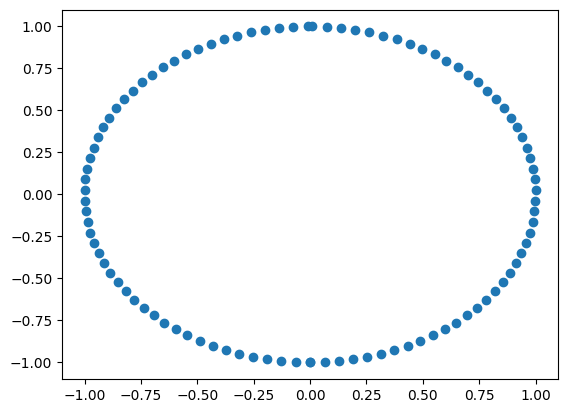

In [ ]:
#| eval: false
fake_yaw_raw_data = np.concatenate((np.linspace(0.01,np.pi), np.linspace(-np.pi, -0.01)))
fake_data_x = np.cos(fake_yaw_raw_data)
fake_data_y = np.sin(fake_yaw_raw_data)

plt.scatter(fake_data_y, fake_data_x);

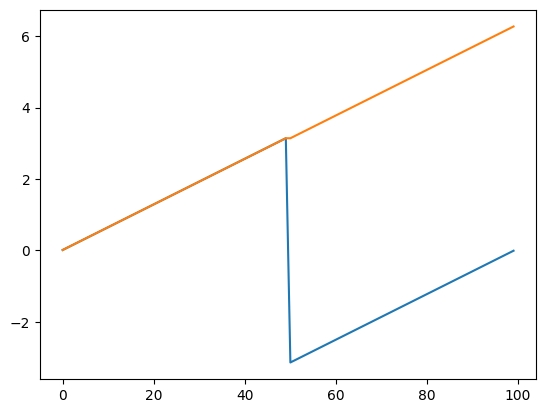

In [ ]:
#| eval: false
fake_yaw = np.arctan2(fake_data_y, fake_data_x)
fake_yaw_corrected = np.arctan2(fake_data_y, fake_data_x)
fake_yaw_corrected[fake_yaw_corrected < 0] += 2.*np.pi
plt.plot(fake_yaw)
plt.plot(fake_yaw_corrected);

From this trick, we can simply detect the end of each projection line by checking when the diference between adjacent angles is smaller than some threshold. After some experimentation with different samples, a threshold of $-\pi$ seems to be robust even if there are some missing readings from the LiDAR.

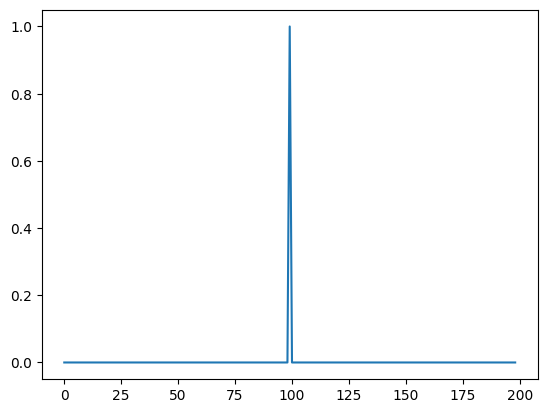

In [ ]:
#| eval: false
two_lines = np.concatenate((fake_yaw_corrected, fake_yaw_corrected))
jump = two_lines[1:] - two_lines[:-1] < -np.pi
plt.plot(jump);

In [ ]:
#| exports
class ProjectionTransform(nn.Module):
    "Pytorch transform that turns a point cloud frame and its respective label and mask arrays into images in given projection style."
    def __init__(self, projection):
        super().__init__()
        self.projection = projection
        self.W = projection.W
        self.H = projection.H
        
    def forward(self, item):
        frame = item['frame']
        label = item['label']
        mask = item['mask']
        
        # get point_cloud components
        scan_xyz = frame[:,:3]
        reflectance = frame[:, 3]

        assert reflectance.max() <= 1.
        assert reflectance.min() >= 0.

        # get depths of all points
        depth = np.linalg.norm(scan_xyz, 2, axis=1)

        # get projections and outliers
        proj_x, proj_y, outliers = self.projection.get_xy_projections(scan_xyz, depth)

        # filter outliers
        if outliers is not None:
            proj_x = proj_x[~outliers]
            proj_y = proj_y[~outliers]
            scan_xyz = scan_xyz[~outliers]
            reflectance = reflectance[~outliers]
            depth = depth[~outliers]
            if label is not None:
                label = label[~outliers]
                mask = mask[~outliers]
        
        # order in decreasing depth
        order = np.argsort(depth)[::-1]
        info_list = [
            scan_xyz,
            reflectance[..., np.newaxis],
            depth[..., np.newaxis]
        ]
        if label is not None:
            info_list += [mask[..., np.newaxis]]
            info_list += [label[..., np.newaxis]]
            
        scan_info = np.concatenate(info_list, axis=-1)
        scan_info = scan_info[order]
        proj_y = proj_y[order]
        proj_x = proj_x[order]
        
        # setup the image tensor
        projections_img = np.zeros((self.H, self.W, 2+len(info_list)), dtype=np.float32)
        projections_img[:,:,-1] -= 1 # this helps to identify points in the projection with no LiDAR readings
        projections_img[proj_y, proj_x] = scan_info
        
        if label is not None:
            frame_img = projections_img[:,:,:-2]
            label_img = projections_img[:,:,-1].astype(np.int32)
            mask_img = projections_img[:,:,-2].astype(bool)
            mask_img = mask_img & (label_img > -1)
        else:
            frame_img = projections_img
            label_img = None
            mask_img = projections_img[:,:,-1] >= 0
        
        item = {
            'frame': frame_img,
            'label': label_img,
            'mask': mask_img,
        }
        return item

With one of the projection algorithms described previously, we can construct a `ProjectionTransform` object that can be used with the `SemanticKITTIDataset`. Here is an example on how to use it:

In [ ]:
#| eval: false
proj = SphericalProjection(fov_up_deg=3., fov_down_deg=-25., W=1024, H=64) # these values were taken from [https://github.com/PRBonn/semantic-kitti-api/blob/master/auxiliary/laserscan.py]
tfms = ProjectionTransform(proj)
ds.set_transform(tfms)
item = ds[128]

As we can see below, the data is still returned as numpy arrays, but their shapes have changed as follows:

- `frame`: an image of HxW resolution with 5 channels with floats (i.e. x, y, z, reflectance, depth);
- `label`: an image of HxW resolution with a single channel with integers;
- `mask`: an image of HxW resolution with a single channel with booleans.

There are a lot of pixels in these projection images that have no corresponding LiDAR readings to be projected. Hence, these pixels were filled with:

- in `frame`: array(\[0., 0., 0., 0., 0.\])
- in `label`: -1
- in `mask`: False

The mask image provides a convenient boolean mask to easily identify pixels with valid LiDAR readings marked as *True* and pixels with no LiDAR readings marked as *False*.

In [ ]:
#| eval: false
frame_img = item['frame']
frame_img[:2], frame_img.shape, frame_img.dtype

(array([[[  0.       ,   0.       ,   0.       ,   0.       ,
            0.       ],
         [  0.       ,   0.       ,   0.       ,   0.       ,
            0.       ],
         [  0.       ,   0.       ,   0.       ,   0.       ,
            0.       ],
         ...,
         [  0.       ,   0.       ,   0.       ,   0.       ,
            0.       ],
         [  0.       ,   0.       ,   0.       ,   0.       ,
            0.       ],
         [  0.       ,   0.       ,   0.       ,   0.       ,
            0.       ]],
 
        [[  0.       ,   0.       ,   0.       ,   0.       ,
            0.       ],
         [  0.       ,   0.       ,   0.       ,   0.       ,
            0.       ],
         [  0.       ,   0.       ,   0.       ,   0.       ,
            0.       ],
         ...,
         [-51.240726 ,   0.7981246,   2.022291 ,   0.21     ,
           51.286827 ],
         [-50.624985 ,   0.3961611,   2.000314 ,   0.17     ,
           50.66604  ],
         [-51.28182  , 

In [ ]:
#| eval: false
label_img = item['label']
label_img[:2], label_img.shape, label_img.dtype, set(label_img.flatten())

(array([[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ...,  0,  0,  0]], dtype=int32),
 (64, 1024),
 dtype('int32'),
 {-1, 0, 1, 9, 11, 13, 14, 15, 16, 17, 18, 19})

In [ ]:
#| eval: false
mask_img = item['mask']
mask_img[:2], mask_img.shape, mask_img.dtype

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 (64, 1024),
 dtype('bool'))

In [ ]:
#| exports
class ProjectionVizTransform(nn.Module):
    "Pytorch transform to preprocess projection images for proper visualization."
    def __init__(self, color_map_rgb_np, learning_map_inv_np, scaling_values):
        super().__init__()
        self.color_map_rgb_np = color_map_rgb_np
        self.learning_map_inv_np = learning_map_inv_np
        self.scaling_values = scaling_values
    
    def scale(self, img, min_value, max_value):
        assert img.max() <= max_value
        assert img.min() >= min_value
        assert max_value > min_value
        
        img = img.clip(min_value, max_value)
        return (255.*(img - min_value)/(max_value - min_value)).astype(int)
    
    def forward(self, item):
        frame_img = item['frame']
        label_img = item['label']
        mask_img = item['mask']
        
        normalized_frame_img = None
        if frame_img is not None:
            x = self.scale(frame_img[:,:,0], self.scaling_values["x"]["min"], self.scaling_values["x"]["max"])
            y = self.scale(frame_img[:,:,1], self.scaling_values["y"]["min"], self.scaling_values["y"]["max"])
            z = self.scale(frame_img[:,:,2], self.scaling_values["z"]["min"], self.scaling_values["z"]["max"])
            r = self.scale(frame_img[:,:,3], self.scaling_values["r"]["min"], self.scaling_values["r"]["max"])
            d = self.scale(frame_img[:,:,4], self.scaling_values["d"]["min"], self.scaling_values["d"]["max"])
            normalized_frame_img = np.stack((x, y, z, r, d), axis=-1)
            normalized_frame_img[mask_img == False] *= 0

        colored_label_img = None
        if label_img is not None:
            label_img[mask_img] = self.learning_map_inv_np[label_img[mask_img]]
            colored_label_img = np.zeros(label_img.shape + (3,))
            colored_label_img[mask_img] = self.color_map_rgb_np[label_img[mask_img]]
            colored_label_img = colored_label_img.astype(int)
        
        item = {
            'frame': normalized_frame_img,
            'label': colored_label_img,
            'mask': mask_img,
        }
        return item

In order to plot comparable visualizations of the projections, we need to standardize the scale of the float channels from the frame projection and map the label integers to their corresponding RGB color defined in the `color_map` dict from the yaml file that was downloaded before. 

After experimenting with several samples from the dataset, the scale values in the table below were found to produce reasonable results. If you are using a dataset other than SemanticKITTI, these values may need to be adjusted accordingly.

| Feature   | Min     | Max    |
|-----------|---------|--------|
| **x**     | -100.0  | 100.0  |
| **y**     | -100.0  | 100.0  |
| **z**     | -31.0   | 5.0    |
| **r**     | 0.0     | 1.0    |
| **d**     | 0.0     | 100.0  |

Here is an example on how to use and compose the previous transforms with the `torchvision.transforms.v2` module, and then visualize the resulting images with the `matplolib.pyplot` module:

In [ ]:
#| eval: false
def plot_projections(img, label):
    fig, axs = plt.subplots(6, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd', 'label'])):
        if i < 5:
            ax.imshow(img[:,:,i])
        else:
            ax.imshow(label)
        ax.set_title(title)
        ax.axis('off')

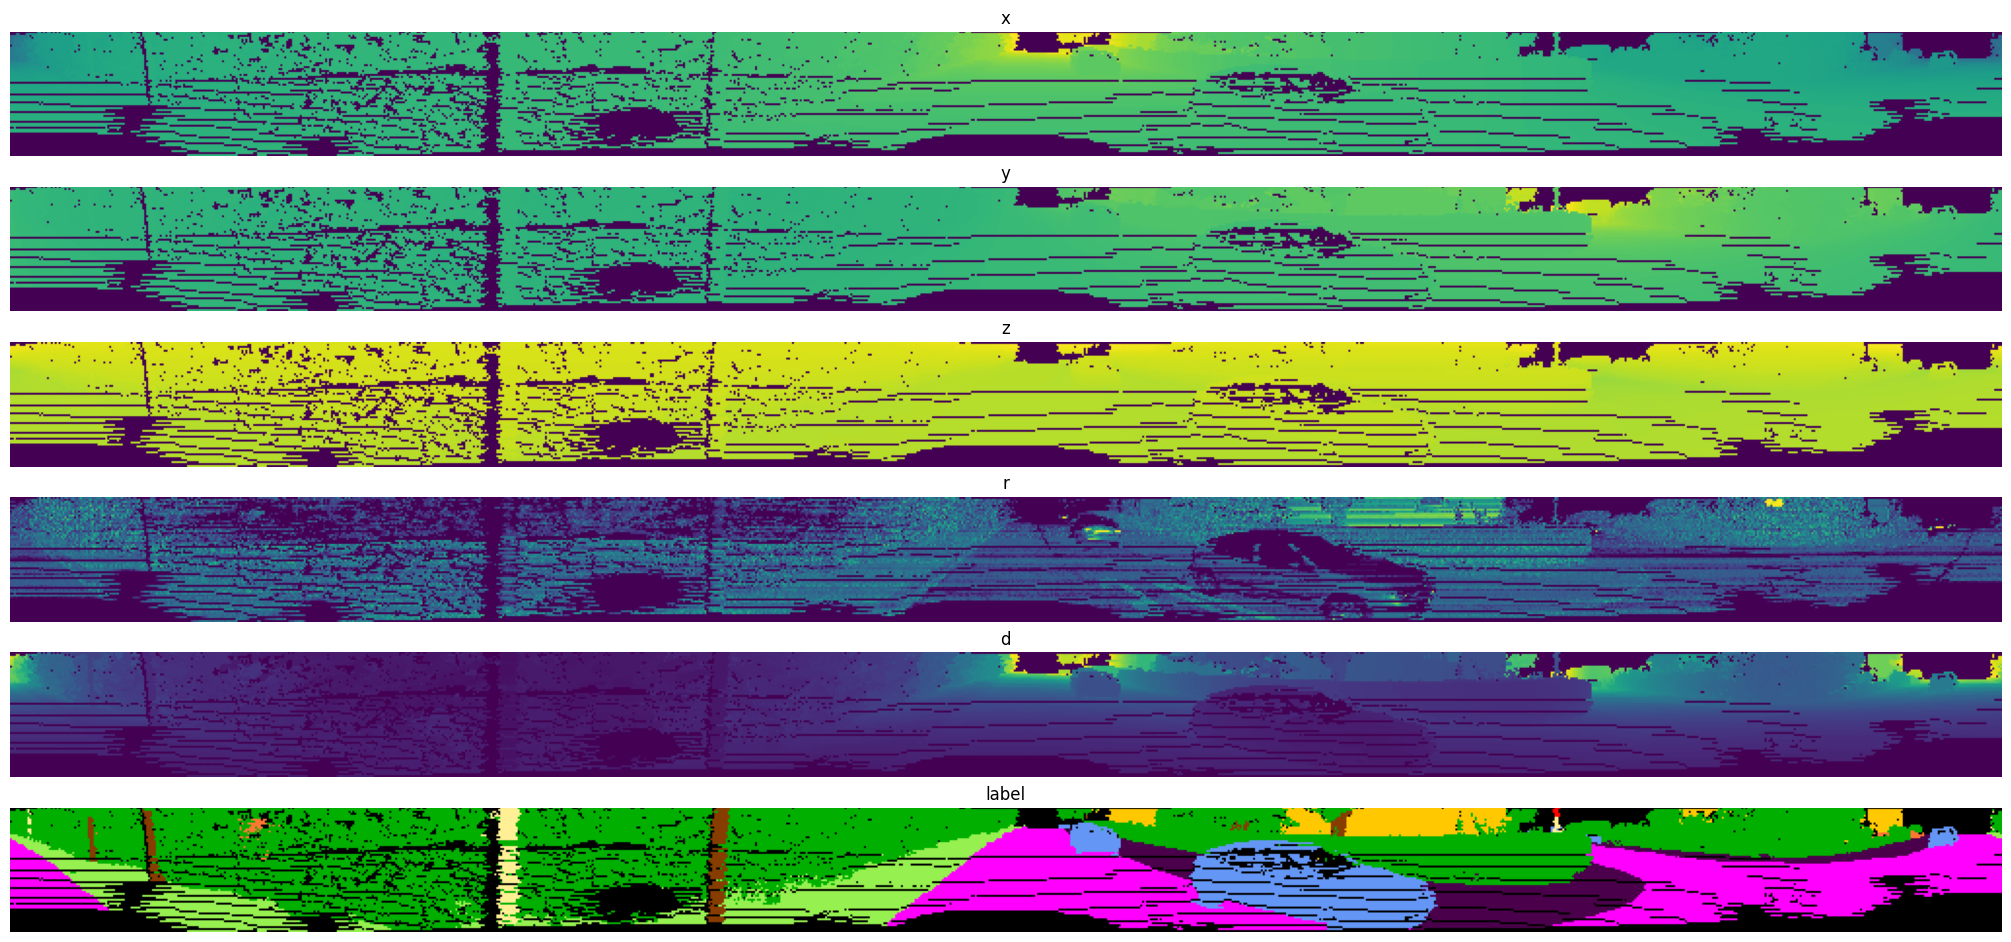

In [ ]:
#| eval: false
proj = SphericalProjection(fov_up_deg=3., fov_down_deg=-25., W=1024, H=64) # these values were taken from [https://github.com/PRBonn/semantic-kitti-api/blob/master/auxiliary/laserscan.py]
scaling_values = {
    "x" : {"min": -100., "max":100.},
    "y" : {"min": -100., "max":100.},
    "z" : {"min": -31., "max":5.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":100.}
}
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np, scaling_values),
])
ds.set_transform(tfms)
item = ds[128]
img = item['frame']
label = item['label']

plot_projections(img, label)

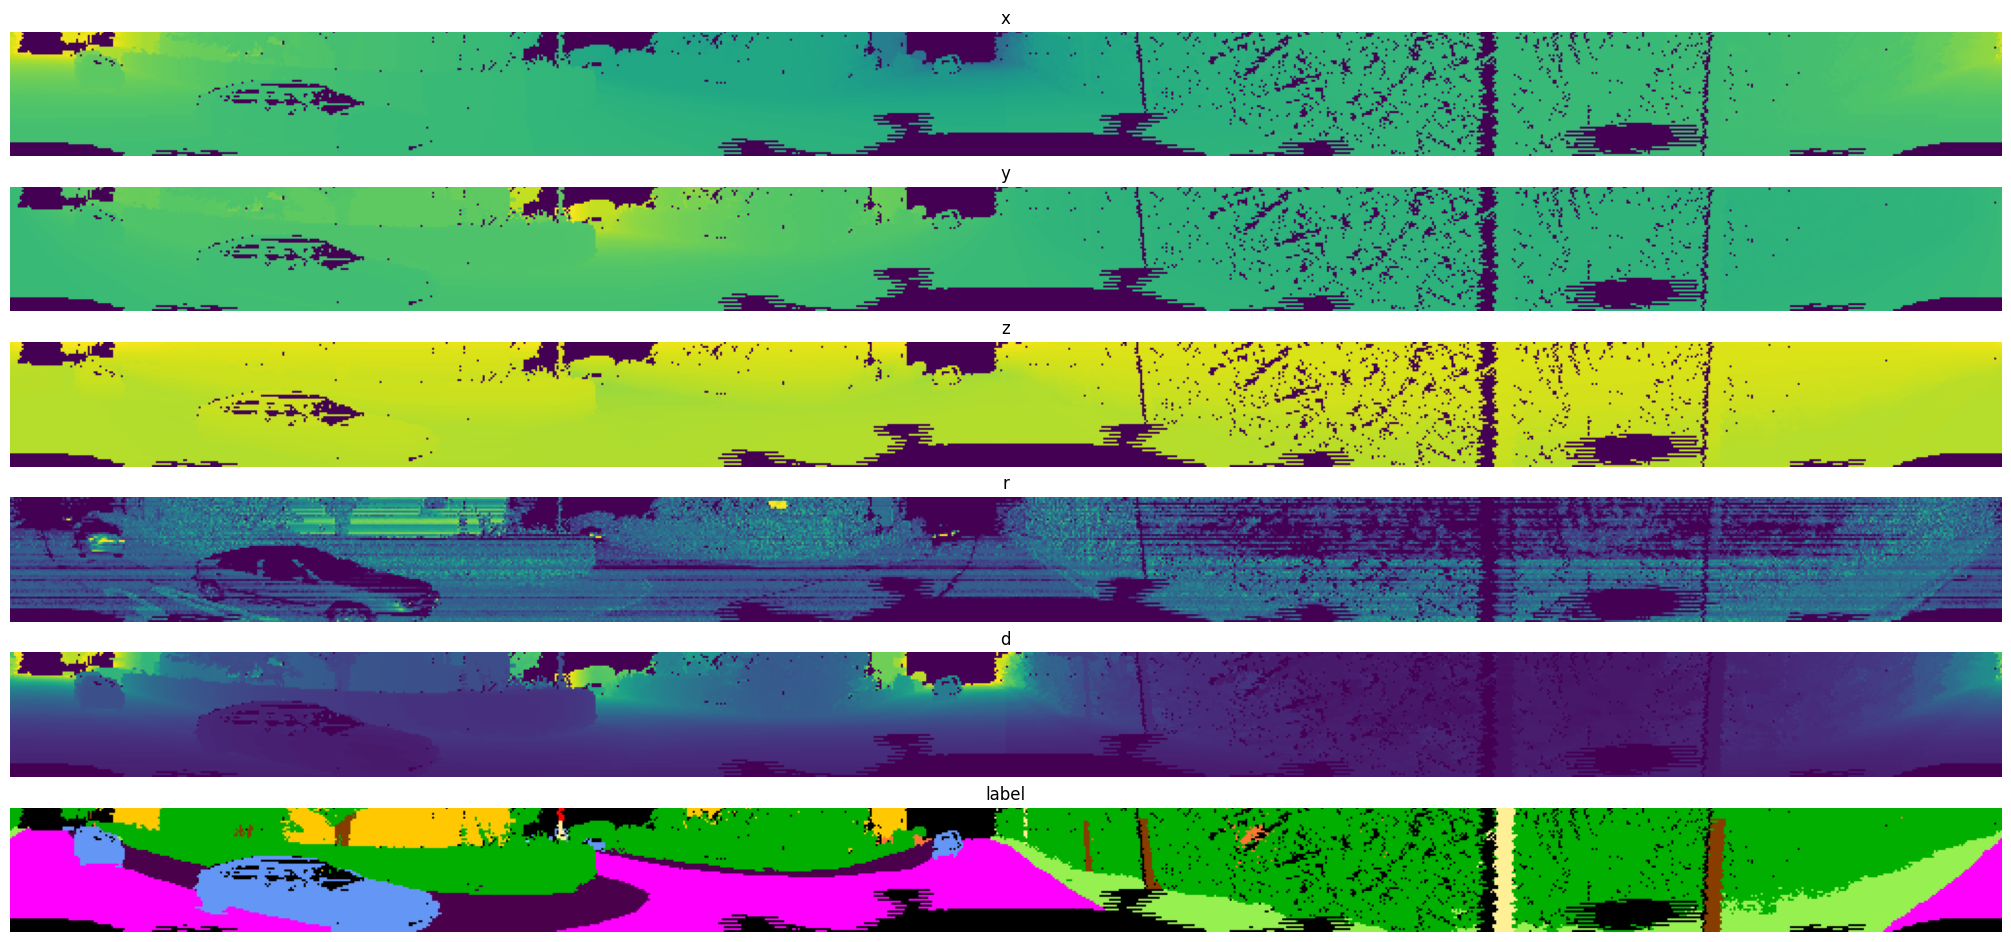

In [ ]:
#| eval: false
proj = UnfoldingProjection(W=1024, H=64)
scaling_values = {
    "x" : {"min": -100., "max":100.},
    "y" : {"min": -100., "max":100.},
    "z" : {"min": -31., "max":5.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":100.}
}
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np, scaling_values),
])
ds.set_transform(tfms)
item = ds[128]
img = item['frame']
label = item['label']

plot_projections(img, label)

In the next cell, we can see how long it takes on average to sample an item from this dataset class.

In [ ]:
#| eval: false
%timeit item = ds[0]

13.1 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
#| exports
class ProjectionToTensorTransform(nn.Module):
    "Pytorch transform that converts the projections from np.array to torch.tensor. It also changes the frame image format from (H, W, C) to (C, H, W)."
    def forward(self, item):
        frame_img = item['frame']
        label_img = item['label']
        mask_img = item['mask']
        
        frame_img = np.transpose(frame_img, (2, 0, 1))
        frame_img = torch.from_numpy(frame_img).float()
        if label_img is not None:
            label_img = torch.from_numpy(label_img).long()
        if mask_img is not None:
            mask_img = torch.from_numpy(mask_img)

        item = {
            'frame': frame_img,
            'label': label_img,
            'mask': mask_img,
        }
        return item

In order to use the dataset to train pytorch models, it is necessary to transform the data from `np.array`s to `torch.tensor`s. Also, for the frame images, it is necessary to transpose (or permute in torch lingo) its axis from *channels last* (H, W, C) to *channels first* (C, H, W).

Here is an example on how to use it with the scan unfolding projection:

In [ ]:
#| eval: false
proj = UnfoldingProjection(W=1024, H=64)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionToTensorTransform(),
])
ds.set_transform(tfms)

item = ds[0]
img = item['frame']
label = item['label']
mask = item['mask']

print(img.shape, img.type())
print(label.shape, label.type())
print(mask.shape, mask.type())

torch.Size([5, 64, 1024]) torch.FloatTensor
torch.Size([64, 1024]) torch.LongTensor
torch.Size([64, 1024]) torch.BoolTensor


Here is an example on how to combine the classes above to implement a `torch.utils.data.Dataloader` that iterates on batches of frame, label, mask and weight images:

In [ ]:
#| eval: false
bs = 10
dl = DataLoader(ds, bs, num_workers=8)
for batch in dl:
    item = batch
    img = item['frame']
    label = item['label']
    mask = item['mask']
    print(f"Shape of img \t [N, C, H, W]: \t {img.shape}")
    print(f"Shape of label \t [N, H, W]: \t {label.shape}")
    print(f"Shape of mask \t [N, H, W]: \t {mask.shape}")
    break

Shape of img 	 [N, C, H, W]: 	 torch.Size([10, 5, 64, 1024])
Shape of label 	 [N, H, W]: 	 torch.Size([10, 64, 1024])
Shape of mask 	 [N, H, W]: 	 torch.Size([10, 64, 1024])


In the next cell, we can see how long it takes on average to iterate the dataloader for 1 epoch.

In [ ]:
#| eval: false
from tqdm.auto import tqdm

In [ ]:
#| eval: false
for batch in tqdm(dl):
    item = batch

  0%|          | 0/1913 [00:00<?, ?it/s]

## Remapping the labels

The paper [MVLidarNet: Real-Time Multi-Class Scene Understanding for Autonomous Driving Using Multiple Views](https://arxiv.org/pdf/2006.05518) proposes a different mapping of the labels for training than the one proposed by the yaml in the semantic-kitti-api. They only use the following 7 classes:

- car
- truck
- person/pedestrians
- cyclist
- road
- sidewalk

From the [preferred yaml file](https://github.com/PRBonn/semantic-kitti-api/blob/master/config/semantic-kitti.yaml), we can use the following remapping rules dictionary and the method `learning.remap` from the dataset to apply the remapping:

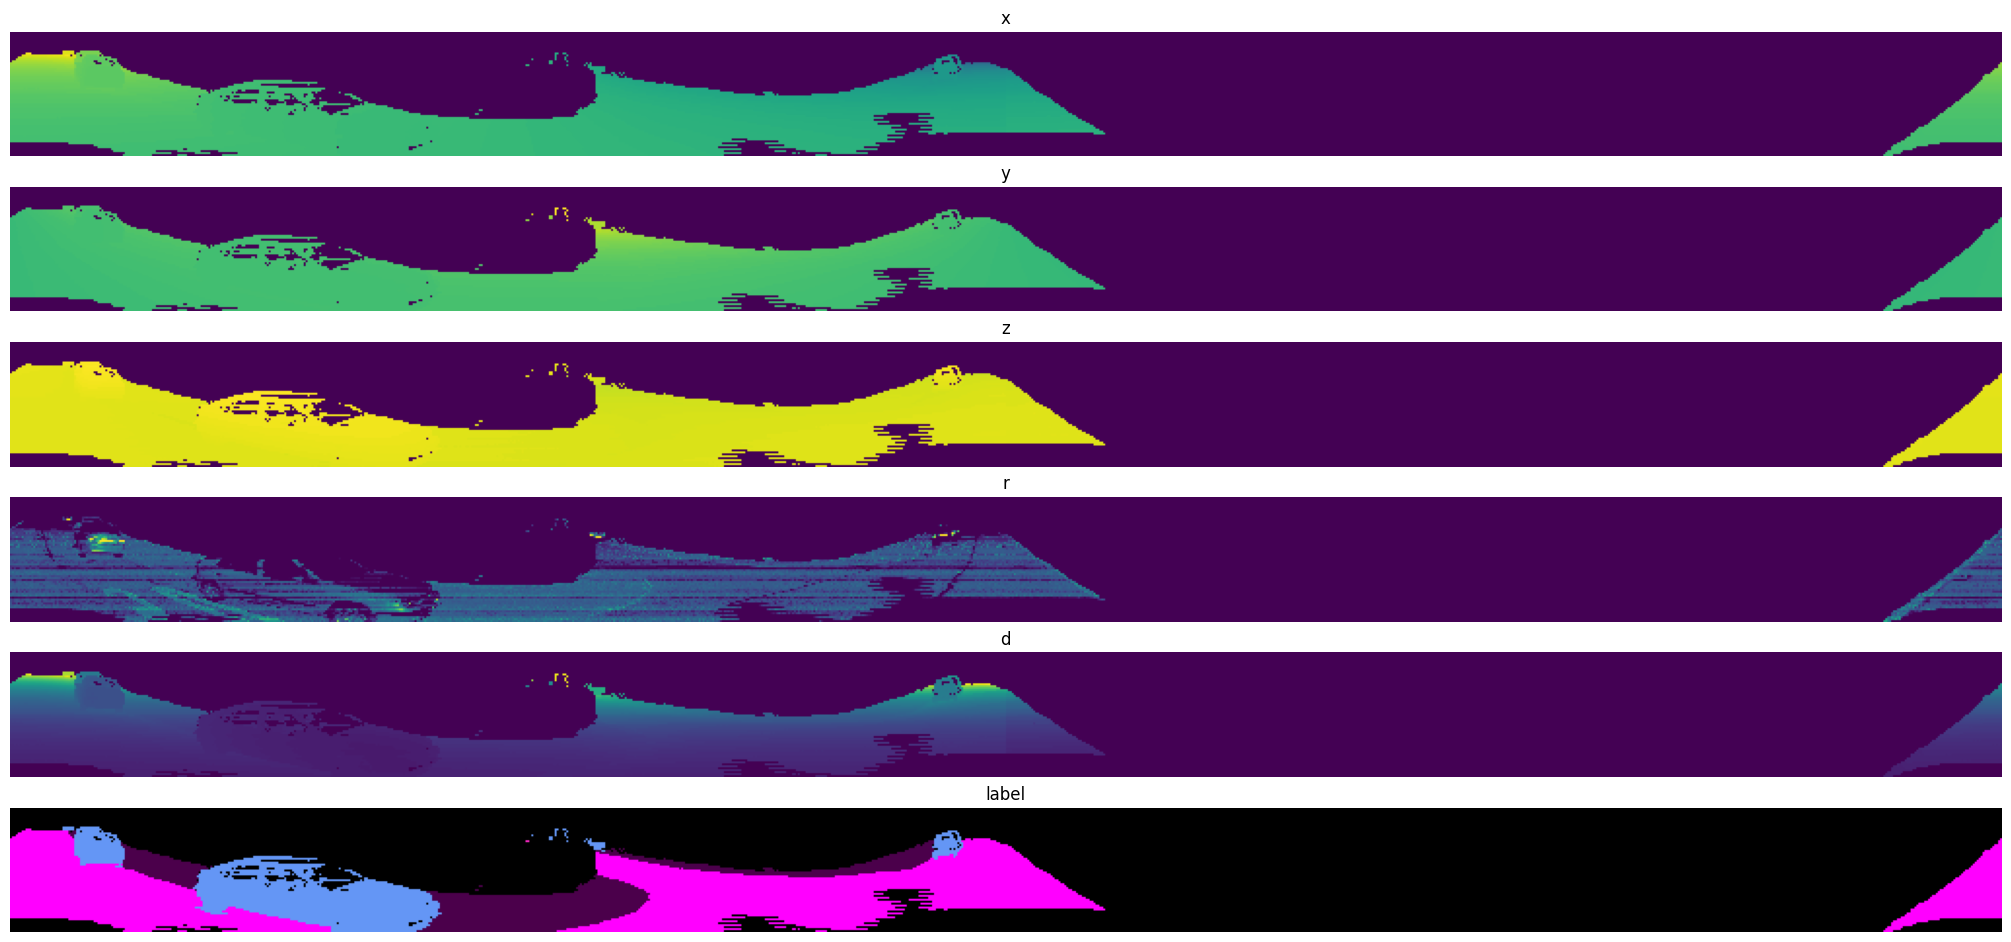

In [ ]:
#| eval: false
remapping_rules = {
    1: 1,
    4: 2,
    6: 3,
    7: 4,
    2: 4,
    9: 5,
    11: 6
}
ds.learning_remap(remapping_rules)

scaling_values = {
    "x" : {"min": -100., "max":100.},
    "y" : {"min": -100., "max":100.},
    "z" : {"min": -31., "max":5.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":100.}
}

tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np, scaling_values),
])
ds.set_transform(tfms)
item = ds[128]
img = item['frame']
label = item['label']

plot_projections(img, label)

## Exploratory Data Analysis (EDA)

During training, we noticed some samples had significant portions of their projection images missing. We plotted an example of such image in the next cell.

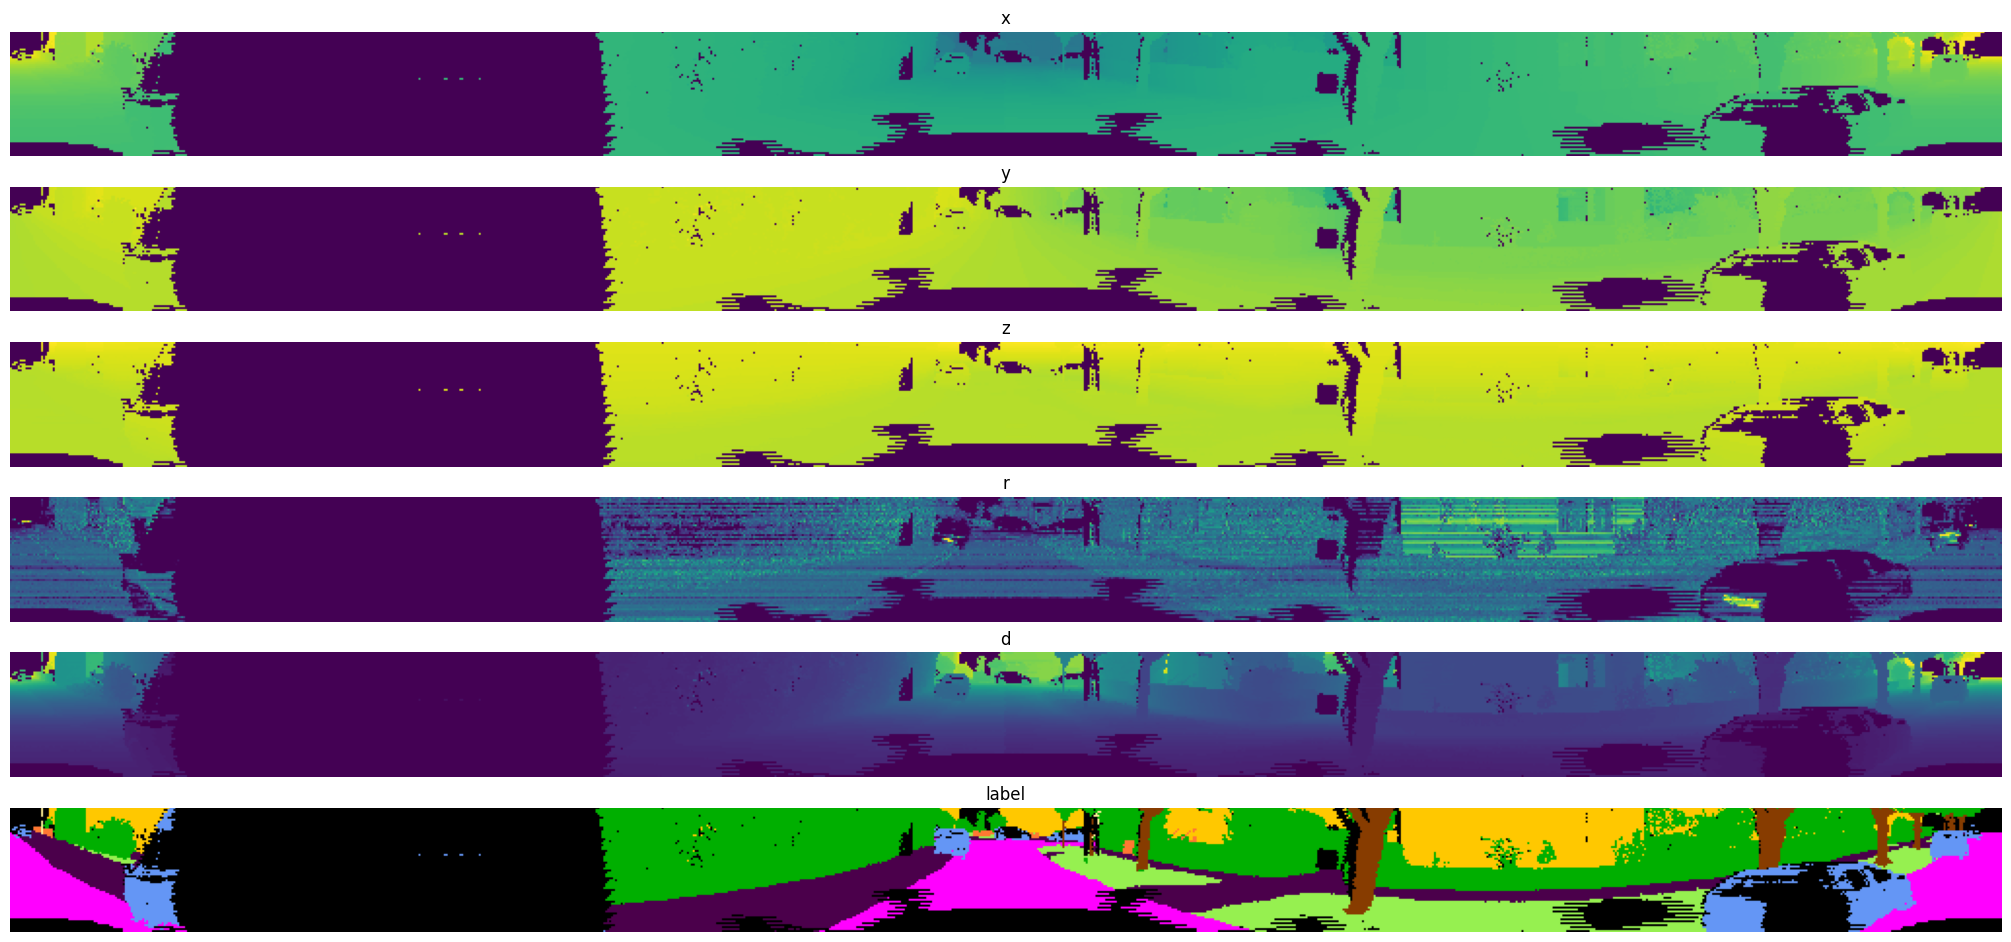

In [ ]:
#| eval: false
ds = SemanticKITTIDataset(data_path)
proj = UnfoldingProjection(W=1024, H=64)
tfm = ProjectionTransform(proj)
ds.set_transform(tfm)

bs = 1000
dl = DataLoader(ds, bs)
item = next(iter(dl))
img = item['frame']
label = item['label']
mask = item['mask']

idx = ((label <= 0).sum(axis=1) > 60).sum(axis=1).argmax()

scaling_values = {
    "x" : {"min": -100., "max":100.},
    "y" : {"min": -100., "max":100.},
    "z" : {"min": -31., "max":5.},
    "r" : {"min": 0., "max":1.},
    "d" : {"min": 0., "max":100.}
}
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np, scaling_values),
])
ds.set_transform(tfms)

item = ds[idx]
i = item['frame']
l = item['label']
plot_projections(i, l)

This level of sparsity could be detrimental to convolutional models, but the total number of samples where this happens seem to be very small with respect to the dataset size. From the best of our knowledge, we haven't seen this explicitly reported anywhere before.

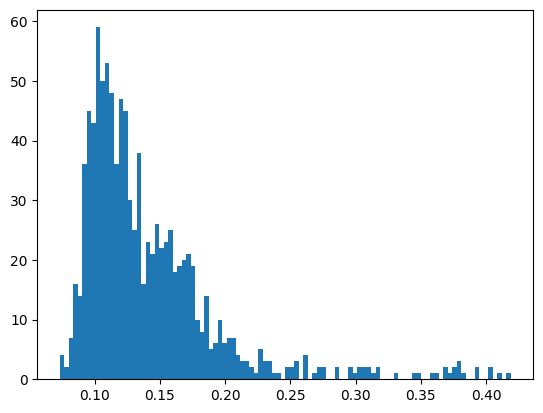

In [ ]:
#| eval: false
ds.set_transform(tfm)

bs = 1000
dl = DataLoader(ds, bs, shuffle=True)
item = next(iter(dl))
img = item['frame']
label = item['label']
mask = item['mask']

sparsity = (label <= 0).sum(axis=(1,2))/label[0].numel()
plt.hist(sparsity, bins=100);

In the next cell we can see how unballanced the dataset is with the `motorcyclist` class (id 8) having 4 orders of magnitude less segmented pixels than classes such as `vegetation` (id 15) for example. This is reported with *Figure 3* in the original paper.

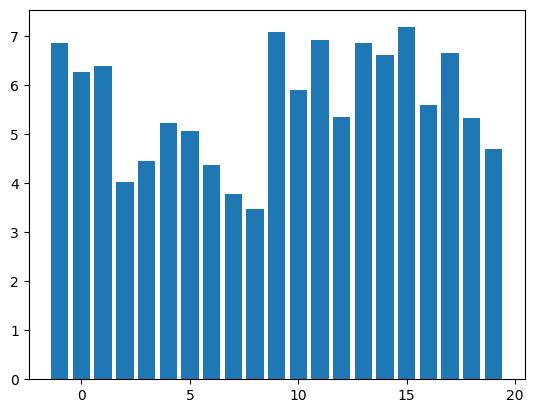

In [ ]:
#| eval: false
l = label.flatten()
values, counts = np.unique(l, return_counts=True)
plt.bar(values, np.log10(counts));

## DataLoaders for benchmarking

When benchmarking different semantic segmentation algorithms, the following DataLoaders should be used.

::: {.callout-warning}
Data augmentation transforms can be applied **before** (`aug_pre_tfms`) or **after** (`aug_post_tfms`) the projection transforms.
:::

In [ ]:
#| exports
def get_benchmarking_dls(
    data_path,
    proj_style='unfold',
    proj_kargs={'W': 512, 'H': 64},
    remapping_rules=None,
    train_batch_size=8, 
    val_batch_size=16,
    num_workers=8,
    aug_pre_tfms=None,
    aug_post_tfms=None
):
    proj_class = {
        'unfold': UnfoldingProjection,
        'spherical': SphericalProjection
    }
    assert proj_style in proj_class.keys()
    proj = proj_class[proj_style](**proj_kargs)

    val_tfms = v2.Compose([
        ProjectionTransform(proj),
        ProjectionToTensorTransform(),
    ])
    if aug_pre_tfms is None:
        aug_pre_tfms = nn.Identity()
    if aug_post_tfms is None:
        aug_post_tfms = nn.Identity()
    train_tfms = v2.Compose([
        aug_pre_tfms,
        val_tfms,
        aug_post_tfms
    ])
    
    train_ds = SemanticKITTIDataset(data_path, 'train', train_tfms, remapping_rules=remapping_rules)
    train_dl = DataLoader(train_ds, batch_size=train_batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    
    val_ds = SemanticKITTIDataset(data_path, 'valid', val_tfms, remapping_rules=remapping_rules)
    val_dl = DataLoader(val_ds, batch_size=val_batch_size, num_workers=num_workers)
    
    return train_dl, val_dl

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()